# Project 5 : Predict markets stocks of Google, Facebook & Amazon.

## MAP670G - Data Stream (2021-2022)
<blockquote> 
Alexandre PERBET<br>
Cyril NERIN<br>
Hugo RIALAN<br>
</blockquote>

__PART 3: PLOT THE RESULTS OF ON-LINE MACHINE LEARNING__

<br>
<img src="Google_Facebook_Amazon.PNG" width="600" height="600">
<br>

__Project 5 : Collect trading data using Yahoo finance API and use online regression to predict markets stocks of Google, Facebook & Amazon.__

__Option 2 :__ For each of these 5 countries, use 1 major industry stock data
For ex, in US Google,  in France BNP Paribas, in China Alibaba, in Russia or England, use a major international industry.
This option was initially given in the project.

For each option, each group should use at least 3 different data streams, with online and adaptive regression on RIVER (such as https://riverml.xyz/latest/api/tree/HoeffdingAdaptiveTreeRegressor/) and compare the performances with batch regression model (scikit-learn).

__ToDo:__ Compare online Regression vs Batch Regression and discuss the performance.

__Bonus :__ Use recent stock market data (from January to March 2022).

__Online resources:__ 
You can use the Python library to collect Yahoo Finance data in streaming https://pypi.org/project/yfinance/
You can compute time-series statistics and moving averages (MACD) for features engineering https://www.statsmodels.org/stable/tsa.html


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

In [13]:
!pip3 install --quiet -r requirements.txt

In [14]:
import sys 
print("Python version: {}". format(sys.version))

import IPython
from IPython import display
from IPython.display import Markdown, display, clear_output
print("IPython version: {}". format(IPython.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
from scipy import stats
print("SciPy version: {}". format(sp.__version__))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version : {}". format(sns.__version__))
sns.set()

import kafka
from kafka.admin import KafkaAdminClient, NewTopic
from kafka import KafkaProducer
from kafka import KafkaConsumer
print("kafka version : {}". format(kafka.__version__))

import yfinance as yf
print("yfinance version : {}". format(yf.__version__))

import statsmodels
print("statsmodels version : {}". format(statsmodels.__version__))
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
print("scikit-learn version : {}". format(sklearn.__version__))

import river
from river import base
from river import compose
from river import metrics
from river import preprocessing
from river import evaluate
from river import tree
from river import ensemble
from river import linear_model
from river import stats
from river import optim
print("river version : {}". format(river.__version__))

import ipywidgets as widgets
print("ipywidgets version : {}". format(widgets.__version__))

import time
from time import perf_counter
from datetime import datetime, date, timedelta

from enum import Enum, auto

import math

import pprint

import json

import urllib.request

import warnings
warnings.filterwarnings('ignore')

print("====================================")

Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
IPython version: 7.27.0
NumPy version: 1.20.3
SciPy version: 1.7.1
pandas version: 1.3.2
matplotlib version: 3.4.2
seaborn version : 0.11.2
kafka version : 2.0.2
yfinance version : 0.1.70
statsmodels version : 0.13.2
scikit-learn version : 1.0.1
river version : 0.9.0
ipywidgets version : 7.6.5


## Utility functions

In [15]:
def printmd(text, couleur=None):
    """
    Printing of the string text by choosing the style (for example bold) and the color (couleur)
    """
    colorstr = "<span style='color:{}'>{}</span>".format(couleur, text)
    display(Markdown(colorstr))

In [16]:
def plot_the_results(dates, y_trues, y_preds, company):
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='True value')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title("On line prediction of the closing price for the {} stock".format(company))
    plt.show()

## Launching the servers
<p><b>LAUNCHING ZOOKEEPER AND KAFKA SERVER ON WINDOWS</b></p>
<p> In a <b>first terminal</b>, run the following commands:
<p>cd %KAFKA_DIR%
<p>.\bin\windows\zookeeper-server-start.bat .\config\zookeeper.properties
<p>  </p>
<p> In a <b>second terminal</b>, run the following commands:
<p>cd %KAFKA_DIR%
<p>.\bin\windows\kafka-server-start.bat .\config\server.properties
<p>  -- </p>
<p>we assume that Zookeeper is running default on localhost:2181 and Kafka on localhost:9092.</p>

# Plot the results from Kafka predict topics

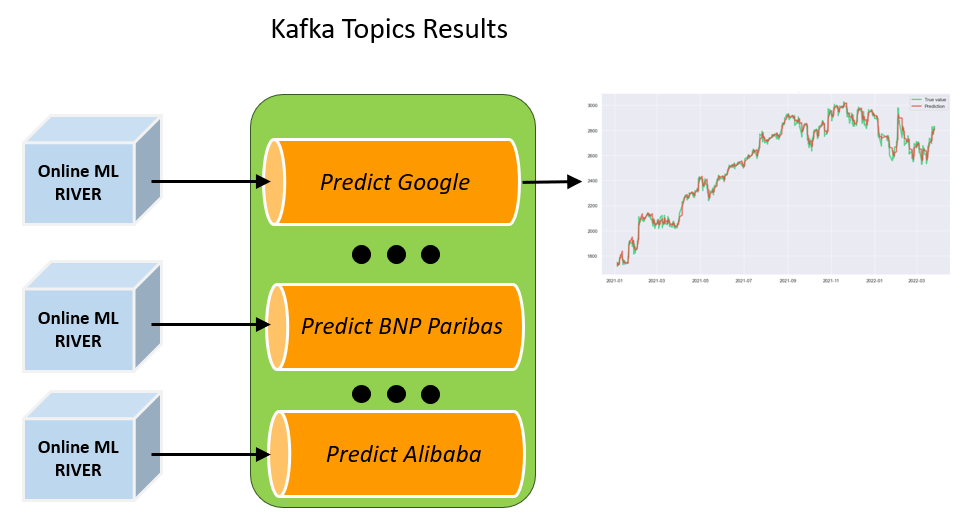

__We create a Kafka topic for each company and stream the stock data retrieved with yfinance into these topics.__

__In another notebook, we will retrieve this stock market data to apply a Machine Learning model with RIVER.__

__In the last notebook, we plot the prediction results from the data stored in the Kafka predicts topics__

## stock market data identifiers

In [17]:
All_the_companies = ["google",
                     "facebook",
                     "amazon",
                     "total",
                     "gazprom",
                     "alibaba",
                     "bnp_paribas",
                     "BP",
                     "ferrari"]

## Notebook settings

In [18]:
trace_plotting = True
Nb_to_update = 500
sommeil = 2
pp = pprint.PrettyPrinter()

## Creation of topics if needed

In [19]:
admin_client = KafkaAdminClient(bootstrap_servers="localhost:9092", client_id="Project_DataStream")

topic_name = {}
topic_predict_name = {}

for company in All_the_companies:
    topic_name[company] = company
    topic_predict_name[company] = "predict__{}".format(company)

    # The stock data
    if topic_name[company] not in admin_client.list_topics():
        topic_list = []
        topic_list.append(NewTopic(name=topic_name[company], num_partitions=1, replication_factor=1))
        admin_client.create_topics(new_topics=topic_list, validate_only=False)

    # The predict results
    if topic_predict_name[company] not in admin_client.list_topics():
        topic_list = []
        topic_list.append(NewTopic(name=topic_predict_name[company], num_partitions=1, replication_factor=1))
        admin_client.create_topics(new_topics=topic_list, validate_only=False)

# Plot the results and the accuracy of the prediction

In [20]:
No_Company = 0              # value from 0 to 8

The_selected_company = All_the_companies[No_Company]
print("The selected company is {}".format(The_selected_company))

The selected company is google


## Visualize the results

In [21]:
def plot_result(The_selected_company): 
    
    if trace_plotting:
        print("-----  PLOTTING THE RESULTS FOR {} ----".format(The_selected_company))

    topic_predict_name = "predict__{}".format(The_selected_company)
    consumer_group_name = "plot_results"

    consumer = KafkaConsumer(topic_predict_name,
                             bootstrap_servers='localhost:9092',
                             group_id=consumer_group_name)

    the_results = {}
    nb_msg = 0
    dates = []
    y_true = []
    y_pred = []
    CPU = []
    MAE = []
    
    try:
        # Infinite loop : the consumer is waiting for message 
        for message in consumer:
            nb_msg += 1
            the_results = json.loads(message.value.decode())
            dates.append(datetime.fromtimestamp(int(the_results["date"] / 1000)))
            y_true.append(the_results["y_true"])
            y_pred.append(the_results["y_pred"])
            CPU.append(the_results["CPU_time"])
            MAE.append(the_results["MAE"])

            if nb_msg % Nb_to_update == 0:
                if trace_plotting:
                    print("update the plots ({} points)".format(nb_msg))
                clear_output(wait=True)
                time.sleep(sommeil)
                plot_the_results(dates, y_true, y_pred, The_selected_company)
                time.sleep(sommeil)

    except KeyboardInterrupt:
        if trace_plotting:
            print ("\n-------  END OF PLOTTING THE RESULTS  -------")
    except Exception as e:
        print("An arror has occurred")
        print(e)

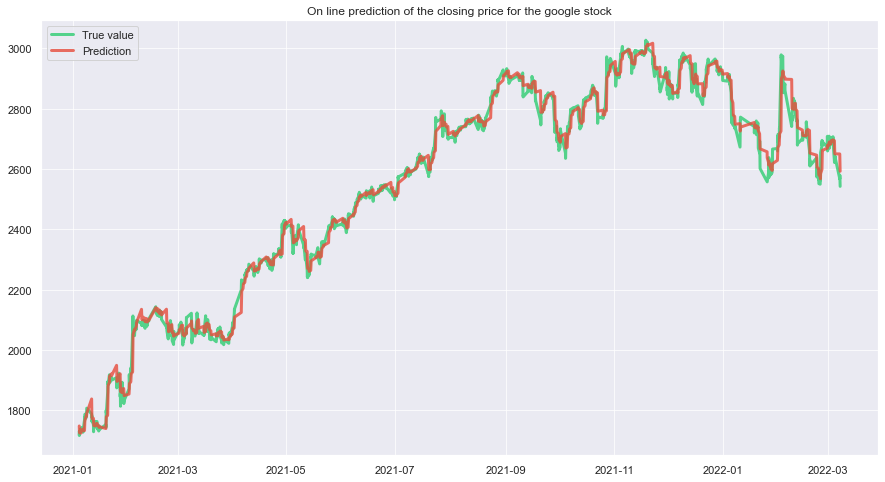


-------  END OF PLOTTING THE RESULTS  -------


In [22]:
plot_result(The_selected_company)